In [1]:
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from skimage import io
import os

import math
import requests

from queue import PriorityQueue

In [2]:
plotly.__version__
pio.renderers.default = "iframe"

In [3]:
np.__version__

'1.24.3'

In [4]:
np.random.seed(0)

In [5]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [6]:
%load_ext autoreload
%autoreload 2

from model import Bicycle, Map
from mppi import MPPI, MPPI_path_follower
from path_planner import a_star_planner
from sim import Simulation


import kmeans, gmm

In [7]:
torch.cuda.empty_cache() 

In [8]:
# avoid = []

# rect = [(20, 0, 80, 50),(20,51,80, 100) ]
# circle= []

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -4.)
# u_max = (10., 4.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

#start at 1-5, 45-55, angle -0

In [9]:
# avoid = []

# rect = [(0, 0, 100, 10),(0, 0, 10, 100), (0, 61, 85, 100), (20, 0, 100, 59),(95,0,100,100) ]
# circle= [(20,40, 6), (10, 30, 6),(10, 50, 6)]

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -4.)
# u_max = (10., 4.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

# #start at (11-19, 11-19), angle math.pi/2

In [41]:
avoid = []

rect = [(0, 15, 47, 85), (53, 15, 100,85)]
left_circles = [(47,20+x, 5) for x in range(0, 80, 20)]
print(left_circles)
right_circles = [(53,30+x, 5) for x in range(0, 60, 20)]
circle= left_circles + right_circles

state_dim = 3
ctrl_dim = 2
u_min = (0., -4.)
u_max = (10., 4.)
step = .05
follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
horizon_depth = 32

# start at (45-55, 1-5), angle math.pi/2
#goal at 50, 90

[(47, 20, 5), (47, 40, 5), (47, 60, 5), (47, 80, 5)]


In [15]:
def get_expert_controls(control_history, horizon_depth, ctrl_dim, interval_start = 0, interval_end = None, interval_step=2, dev="cpu"):
    if(interval_end is None):
        interval_end = len(control_history)-1
    first_rollout = interval_start
    last_rollout = interval_end-horizon_depth
    
    rollout_starts = range(first_rollout, last_rollout+1, interval_step)
    size = len(rollout_starts)
    
    expert_controls = torch.empty([size, horizon_depth, ctrl_dim], dtype = torch.float, device = dev)
    count = 0
    for i in rollout_starts:
        expert_controls[count,:,:] = torch.stack(control_history[i:i+horizon_depth])        
        count+=1
    return expert_controls

In [16]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
print(r+a)
print(t, r, a)
torch.cuda.empty_cache() 

253877248
25426132992 165675008 88202240


In [ ]:
expert_controls = torch.tensor([],device = torch.device('cuda:0')) # used to reset expert_controls from constantly appending
a_star_sim = None
#
for i in range(5):
    for j in range(10):
        x = np.random.uniform(45, 55)
        y = np.random.uniform(1, 5)
        angle = np.random.uniform(5*math.pi/12, 7*math.pi/12)

        if(angle<0):
            angle+=2 * math.pi
            
        a_star_robot = Bicycle(x, y, angle, 0)
        goal = (50, 90, 0, 1)

        mppi_sample_center= torch.tensor([0., 0.])
        mppi_sample_covariance = torch.tensor([[9.,0.],[0., 1]])

        env = Map(goal_point = goal, avoidance_points=avoid, rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))
        a_star_map = Map(goal_point = (a_star_robot.x, a_star_robot.y,4,4), speed_weight = 0, avoidance_points=avoid, 
                         rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))

        def a_star_heuristic(state):     
            return env.terminal_state_cost_batch(state)

        a_star_plan = a_star_planner(a_star_robot, state_dim, ctrl_dim, u_min, u_max, 
                          env.get_obstacles_batch, env.get_distance_batch,
                         iterations = 50000, goal_point = env.goal_point, angle_density = 32, grid_interval = 0.4, goal_tolerance =0.1, 
                                           timestep = step, device=torch.device('cuda:0'))
        
        print (i, j, x, y, "plan ready")
        a_star_follower = MPPI_path_follower(a_star_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max, 
                          a_star_robot.dynamics_batch_horizon, a_star_map, 
                                             a_star_map.running_cost_batch_horizon, a_star_map.terminal_state_cost_batch, a_star_plan.path, 
                         num_samples = 8192, horizon = follow_depth, lambda_=.1, sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        print("expert demo started")
        
        a_star_sim = Simulation(a_star_robot, a_star_follower, a_star_map, goal_tolerance = 1, timestep = step)
        
        iter, goal_reached = a_star_sim.run(500, False, True, True, True, 
                                            write_rollout_start = 0, write_rollouts_num = 10, write_rate = 2)

        if not goal_reached:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            print("L")
        else:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            new_controls = get_expert_controls(a_star_robot.control_history, horizon_depth, ctrl_dim,interval_step = 2, dev = torch.device('cuda:0'))
            
            #expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = 7)
            expert_controls = torch.cat((expert_controls, new_controls), 0)
    
            #expert_means[:, :, -1] = -expert_means[:, :, -1]
            new_controls[:, :, -1] = -new_controls[:, :, -1]
            expert_controls = torch.cat((expert_controls, new_controls), 0)

        
        # losses = []
        # clusters = []
        
        # for num_cluster in range(1, 50, 5):
        #     expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = num_cluster)
        #     losses.append(loss)
        #     clusters.append(num_cluster)
        # plt.plot(clusters, losses)
        # plt.show()
            torch.cuda.empty_cache() 
            print(expert_controls.shape)



0 0 46.210598796010856 1.966182745975853 plan ready
expert demo started
torch.Size([164, 32, 2])
0 1 49.895093288343595 4.566090709967025 plan ready
expert demo started
torch.Size([320, 32, 2])
0 2 48.85237418549928 4.666908077320727 plan ready
expert demo started
torch.Size([476, 32, 2])
0 3 51.311255415710576 1.5312599950747754 plan ready
expert demo started
L
0 4 48.24404863631638 3.720462150508381 plan ready
expert demo started
L
0 5 50.03933611879435 2.184969553484571 plan ready
expert demo started
torch.Size([636, 32, 2])
0 6 48.51870560927256 3.9535613507744505 plan ready
expert demo started
torch.Size([794, 32, 2])
0 7 47.015177133232186 3.1940763851192413 plan ready
expert demo started
torch.Size([954, 32, 2])
0 8 48.48782664170599 1.0984798282258228 plan ready
expert demo started
torch.Size([1118, 32, 2])
0 9 46.318520381629526 3.8316698507017395 plan ready
expert demo started
L
1 0 51.11748414432958 3.687628065119824 plan ready
expert demo started
L
1 1 51.96077168966005 2.5

In [709]:
# a_star_sim.draw_explored(a_star_plan.path, False)

# a_star_sim.display_run()
# a_star_sim.display_history()


torch.cuda.empty_cache()
gmm_means, gmm_cov, gmm_pi, ll = gmm.run_model(expert_controls[0:100], 2)


tensor(9.9550, device='cuda:0') tensor(0.2118, device='cuda:0') tensor(-1.1195e-06, device='cuda:0') tensor(2.0425, device='cuda:0')
e step params
tensor([[-8.3686e-01, -3.7161e-01, -2.6629e-01, -9.5083e-03,  4.9405e-02,
         -4.1967e-02,  4.9819e-02, -4.1967e-02,  4.9823e-02, -4.1614e-02,
          9.5431e-02, -2.8031e-02,  1.3058e-01, -4.6241e-02,  8.0214e-02,
         -5.9825e-02,  5.1784e-02, -5.9825e-02,  5.1784e-02, -5.9824e-02,
          5.3985e-02, -5.9824e-02,  5.3985e-02, -4.1982e-02,  5.3963e-02,
         -4.1984e-02,  5.3963e-02, -5.1601e-02,  5.3963e-02, -5.1601e-02,
          8.8260e-02, -5.1601e-02,  8.8260e-02, -5.1600e-02,  8.8260e-02,
         -6.7302e-04,  1.0533e-01, -6.7302e-04,  1.0533e-01, -6.7548e-04,
          1.0533e-01, -6.7531e-04,  1.0533e-01, -6.7531e-04,  1.0533e-01,
         -6.7532e-04,  1.0533e-01, -3.2045e-04,  1.0533e-01,  7.6712e-03,
          1.0533e-01,  7.6712e-03,  1.0443e-01,  7.6712e-03,  1.0443e-01,
          7.6704e-03,  1.0443e-01,  7.5

In [ ]:
%who

In [19]:
losses = []
clusters = []

for num_cluster in range(1, 21):
    #expert_means, expert_covariances, loss = kmeans.k_means_segment(expert_controls, k = num_cluster)
    expert_means, assignments, loss = kmeans.k_means_segment(expert_controls, k = num_cluster)
    losses.append(loss)
    clusters.append(num_cluster)
    print(num_cluster)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


[439829.625, 416251.5, 402669.71875, 350751.3125, 343263.53125, 339527.40625, 339321.0625, 336037.8125, 334527.46875, 330645.53125, 330711.0625, 328244.0625, 323684.8125, 326768.59375, 322981.5, 321517.09375, 320716.25, 321653.40625, 319743.0625, 319380.9375]


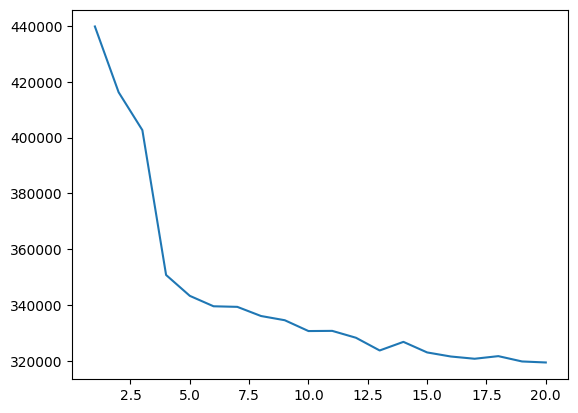

In [20]:
print(losses)
plt.plot(clusters, losses)
plt.show()

In [33]:
num_clusters = 6
expert_means, clusters, loss = kmeans.k_means_segment(expert_controls, k = num_clusters)
print(expert_means.shape)


torch.Size([6, 64, 2])


In [38]:
use_expert_controls = True
samples = 2048
controls = None

expert_samples = [50 for i in range(6)]

if use_expert_controls:
    if expert_samples is not None:
        samples = samples - sum(expert_samples)
        controls = expert_means
    else:
        samples = samples - expert_controls.shape[0]
        controls = expert_controls
    
if(samples <0):
    print("too many expert rollouts")

In [40]:

mppi_sample_center= torch.tensor([0., 0.])
mppi_sample_covariance = torch.tensor([[9.,0.],[0.,1]])
expert_sample_center= torch.zeros(ctrl_dim *horizon_depth)
expert_sample_covariance = torch.tensor([[.09,0.],[0., .01]])
# note: if these parameters are changed, the a-star ones should be changed to match

# changes to 8 clusters

success = 0.
total = 0.
total_it = 0.

for i in range(1):
    for j in range(1):
        x = np.random.uniform(45, 55)
        y = np.random.uniform(1, 5)
        angle = np.random.uniform(5*math.pi/12, 7*math.pi/12)

        if(angle<0):
            angle+=2 * math.pi
            
        mppi_robot = Bicycle(x, y, angle, 0)
        mppi_goal = (50, 90, 1, 10)


        mppi_map = Map(goal_point = mppi_goal, avoidance_points=avoid, 
                       rect_obstacles=rect,circle_obstacles=circle, speed_weight = 0.01, device = torch.device('cuda:0'))
        mppi_controller = MPPI(mppi_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max,
                          mppi_robot.dynamics_batch_horizon, mppi_map.running_cost_batch_horizon, mppi_map.terminal_state_cost_batch,
                               expert_rollouts = controls, expert_samples = expert_samples, 
                               expert_mu = mppi_sample_center, expert_noise = expert_sample_covariance,
                               num_samples = samples, horizon = horizon_depth, lambda_=1,sample_null_action = True,
                               timestep = step, device=torch.device('cuda:0'))
        mppi_sim = Simulation(mppi_robot, mppi_controller, mppi_map, timestep = step, goal_tolerance = 2)

        iterations, completed = mppi_sim.run(iterations=400, draw_obstacles = False, write_snapshots =True, 
              write_rollouts=True, write_controls = True, write_rollout_start = 0, write_rollouts_num = 6,write_rate = 2)
        
        mppi_sim.display_run()

        if completed:
            success+=1
            total_it += iterations
        else:
            
            mppi_sim.display_history()
        total+=1
        
        
        print(i, j, completed, iterations, success/total)
        
print(success/total)
if success > 0:
    print(total_it/success)



0 0 False 132 0.0
0.0
